In [1]:
import pandas as pd
from eia import EnergyDemand, TransportationDemand, FuelCosts
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [ ]:
API = ""
YEAR = 2050
MIN_MAX_YEAR = 2035

SCENARIOS = {
    "reference": "Reference",
    # "aeo2022": "AEO2022",  
    "no_ira": "No IRA",  
    "low_ira": "Low IRA", 
    "high_ira": "High IRA",
    "high_growth": "High Economic Growth", 
    "low_growth": "Low Economic Growth", 
    "high_oil_price": "High Oil Price", 
    "low_oil_price": "Low Oil Price", 
    "high_oil_gas_supply": "High Oil and Gas Supply", 
    "low_oil_gas_supply": "Low Oil and Gas Supply", 
    "high_ztc": "High Zero-Carbon Technology Cost", 
    "low_ztc": "Low Zero-Carbon Technology Cost", 
    "high_growth_high_ztc": " High Economic Growth-High Zero-Carbon Technology Cost",
    "high_growth_low_ztc": "High Economic Growth-Low Zero-Carbon Technology Cost", 
    "low_growth_high_ztc": "Low Economic Growth-High Zero-Carbon Technology Cost", 
    "low_growth_low_ztc": "Low Economic Growth-Low Zero-Carbon Technology Cost",  
    "fast_build_high_lng": "Fast Builds Plus High LNG Price",  
    "high_lng": "High LNG Price",  
    "low_lng": "Low LNG Price",  
}

VEHICLE_CODES = {
    "light_duty": "kei_trv_trn_NA_ldv_NA_NA_blnvehmls",
    "med_duty": "kei_trv_trn_NA_cml_NA_NA_blnvehmls",
    "heavy_duty": "kei_trv_trn_NA_fght_NA_NA_blnvehmls",
    "bus": "_trv_trn_NA_bst_NA_NA_bpm",
    "rail_passenger": "_trv_trn_NA_rlp_NA_NA_bpm",
    "boat_shipping": "kei_trv_trn_NA_dmt_NA_NA_blntnmls",
    "rail_shipping": "kei_trv_trn_NA_rail_NA_NA_blntnmls",
    "air": "kei_trv_trn_NA_air_NA_NA_blnseatmls",
}

In [3]:
def collect_energy_data(sector: str, year: int, api: str) -> pd.DataFrame:
    """Gets AEO energy demand data."""
    df = pd.DataFrame()
    for scenario in SCENARIOS:
        temp = EnergyDemand(sector, year, api, scenario).get_data()
        temp = temp.rename(columns={"value":scenario})
        if df.empty:
            df = temp[scenario].to_frame()
        else:
            df = df.join(temp[scenario].to_frame())
            
    return df.rename(columns=SCENARIOS)

In [4]:
def collect_transport_data(vehicle: str, year: int, api: str) -> pd.DataFrame:
    """Gets AEO transport demand data."""
    df = pd.DataFrame()
    for scenario in SCENARIOS:
        temp = TransportationDemand(vehicle, year, api, "travel", scenario).get_data()
        temp = temp.rename(columns={"value":scenario})
        if df.empty:
            df = temp[scenario].to_frame()
        else:
            df = df.join(temp[scenario].to_frame())
            
    return df.rename(columns=SCENARIOS)

In [5]:
def collect_fuel_data(fuel: str, year: int, api: str) -> pd.DataFrame:
    """Gets AEO fuel cost data."""
    df = pd.DataFrame()
    for scenario in SCENARIOS:
        temp = FuelCosts(fuel, year, api, scenario).get_data()
        temp = temp.rename(columns={"value":scenario})
        if df.empty:
            df = temp[scenario].to_frame()
        else:
            df = df.join(temp[scenario].to_frame())
            
    return df.rename(columns=SCENARIOS)

In [6]:
def calculate_difference(df: pd.DataFrame, min_max_before: int | None = None) -> pd.DataFrame:
    """Gets data as percent difference from Reference scenario."""

    diff = df.copy()

    for col in df:
        diff[col] = ((df[col] - df["Reference"]) / df["Reference"] * 100)
    
    if min_max_before:
        min_diff = round(diff.loc[:min_max_before].min().min(),2)
        max_diff = round(diff.loc[:min_max_before].max().max(),2)
        
        print(f"The minimum differencce before {min_max_before} is: {min_diff} %")
        print(f"The maximum differencce before {min_max_before} is: {max_diff} %")
    
    return diff

In [7]:
def plot_difference(df: pd.DataFrame, title: str | None = None) -> tuple[plt.Figure, plt.axes]:

    fig, axs = plt.subplots(1,1, figsize=(8, 5))

    colors = sns.color_palette("tab10", n_colors=len(SCENARIOS))  # or "Set2", "Paired", etc.
    axs.set_prop_cycle("color", colors)

    df.plot(ylabel="Percent Difference from Reference (%)", xlabel="", ax=axs)
    axs.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
    
    if title:
        axs.set_title(title)

    return fig, axs

In [8]:
def plot_raw_and_diff(
    raw: pd.DataFrame, 
    diff: pd.DataFrame, 
    title: str | None = None, 
    title_raw: str | None = None,
    y_label_raw: str | None = None
) -> tuple[plt.Figure, plt.axes]:
    
    # ensure columns are in the same order 
    diff = diff[raw.columns]
    
    fig, axs = plt.subplots(1,2, figsize=(16, 5))
    
    ylabel_raw = "" if not y_label_raw else y_label_raw
    axs_title_raw = "" if not title_raw else title_raw
    
    raw.plot(title=axs_title_raw, ylabel=ylabel_raw, xlabel="", ax=axs[0], legend=False)
    diff.plot(title="Percent Difference from Reference", ylabel="%", xlabel="", ax=axs[1], legend=False)

    axs[0].get_legend().remove() if axs[0].get_legend() else None
    axs[1].get_legend().remove() if axs[1].get_legend() else None

    colors = sns.color_palette("tab10", n_colors=len(SCENARIOS))  # or "Set2", "Paired", etc.
    axs[0].set_prop_cycle("color", colors)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0), ncols=5)
    
    if title:
        fig.suptitle(title)
        
    

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.3)

    return fig, axs

The minimum differencce before 2035 is: -2.79 %
The maximum differencce before 2035 is: 1.23 %


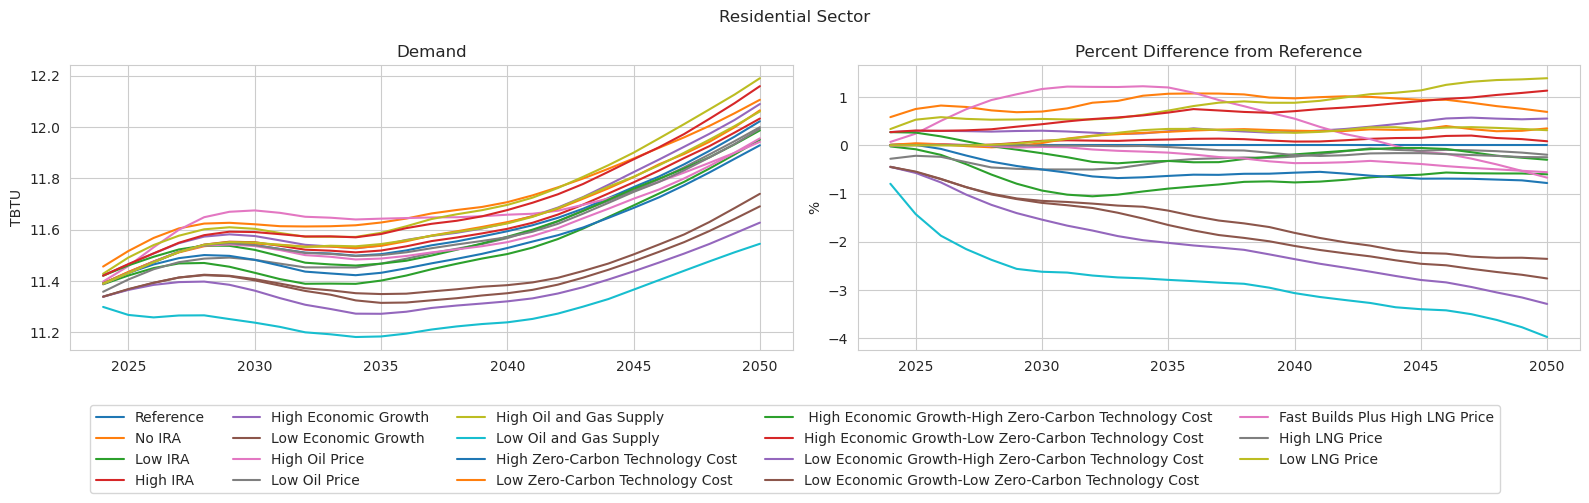

In [9]:
res = collect_energy_data("residential", YEAR, API)
res_diff = calculate_difference(res, MIN_MAX_YEAR)
# fig, ax = plot_difference(res_diff, title="Residential Sector")
fig, ax = plot_raw_and_diff(
    res, 
    res_diff, 
    title="Residential Sector", 
    title_raw="Demand", 
    y_label_raw="TBTU"
)

The minimum differencce before 2035 is: -3.07 %
The maximum differencce before 2035 is: 0.91 %


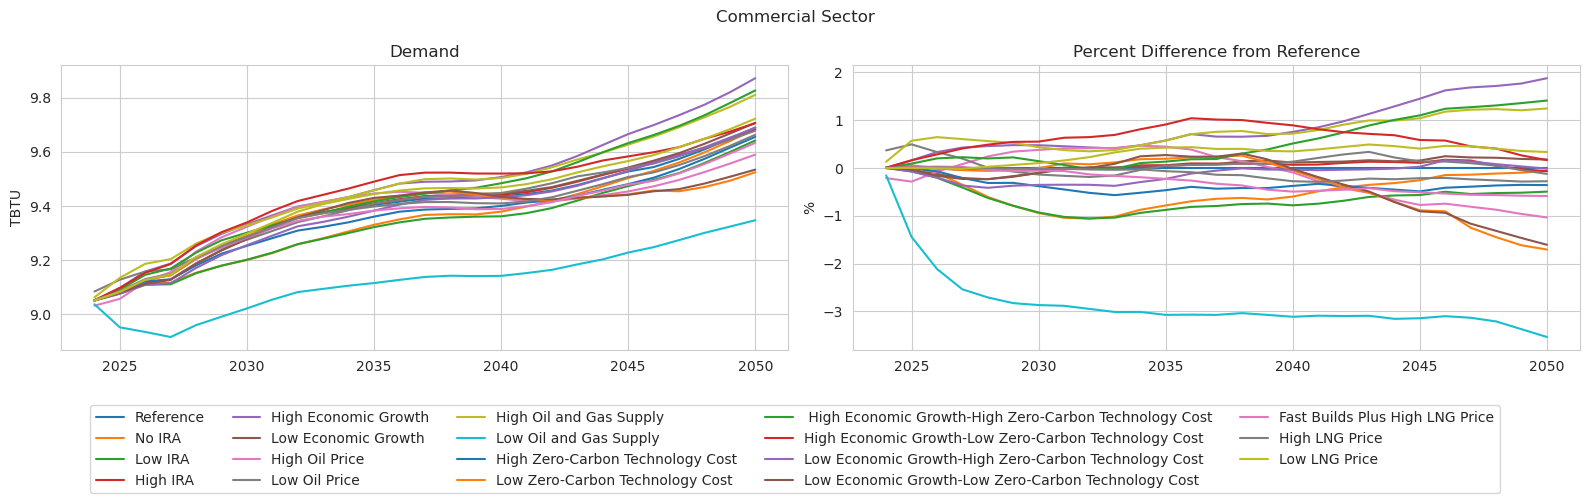

In [10]:
com = collect_energy_data("commercial", YEAR, API)
com_diff = calculate_difference(com, MIN_MAX_YEAR)
# fig, ax = plot_difference(com_diff, title="Commercial Sector")
fig, ax = plot_raw_and_diff(
    com, 
    com_diff, 
    title="Commercial Sector", 
    title_raw="Demand", 
    y_label_raw="TBTU"
)

The minimum differencce before 2035 is: -8.8 %
The maximum differencce before 2035 is: 10.06 %


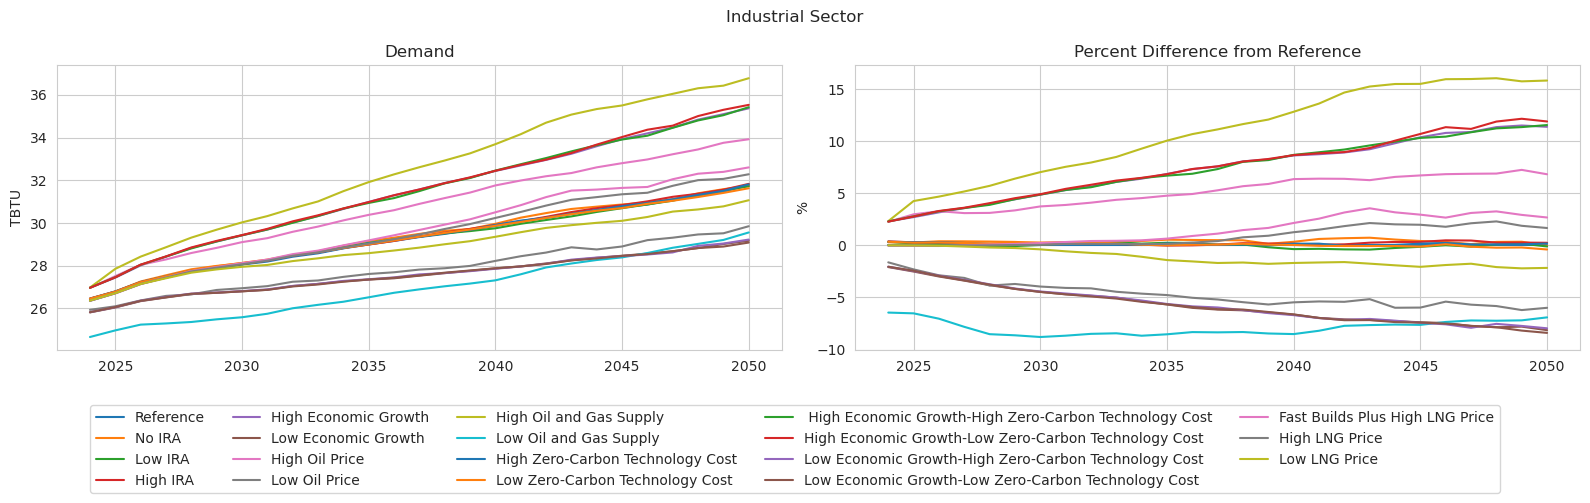

In [11]:
ind = collect_energy_data("industry", YEAR, API)
ind_diff = calculate_difference(ind, MIN_MAX_YEAR)
# fig, ax = plot_difference(ind_diff, title="Industrial Sector")
fig, ax = plot_raw_and_diff(
    ind, 
    ind_diff, 
    title="Industrial Sector", 
    title_raw="Demand", 
    y_label_raw="TBTU"
)

The minimum differencce before 2035 is: -5.18 %
The maximum differencce before 2035 is: 6.65 %


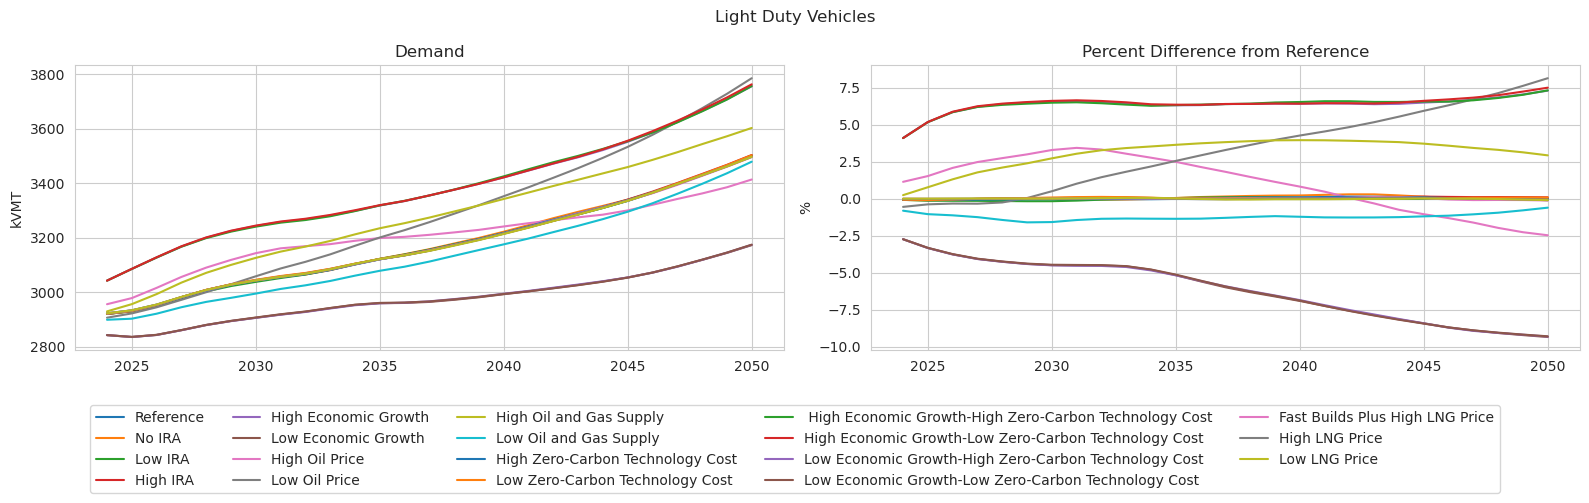

In [12]:
veh = collect_transport_data("light_duty", YEAR, API)
veh_diff = calculate_difference(veh, MIN_MAX_YEAR)
# fig, ax = plot_difference(veh_diff, title="Light Duty Vehicles")
fig, ax = plot_raw_and_diff(
    veh, 
    veh_diff, 
    title="Light Duty Vehicles", 
    title_raw="Demand", 
    y_label_raw="kVMT"
)

The minimum differencce before 2035 is: -8.08 %
The maximum differencce before 2035 is: 8.77 %


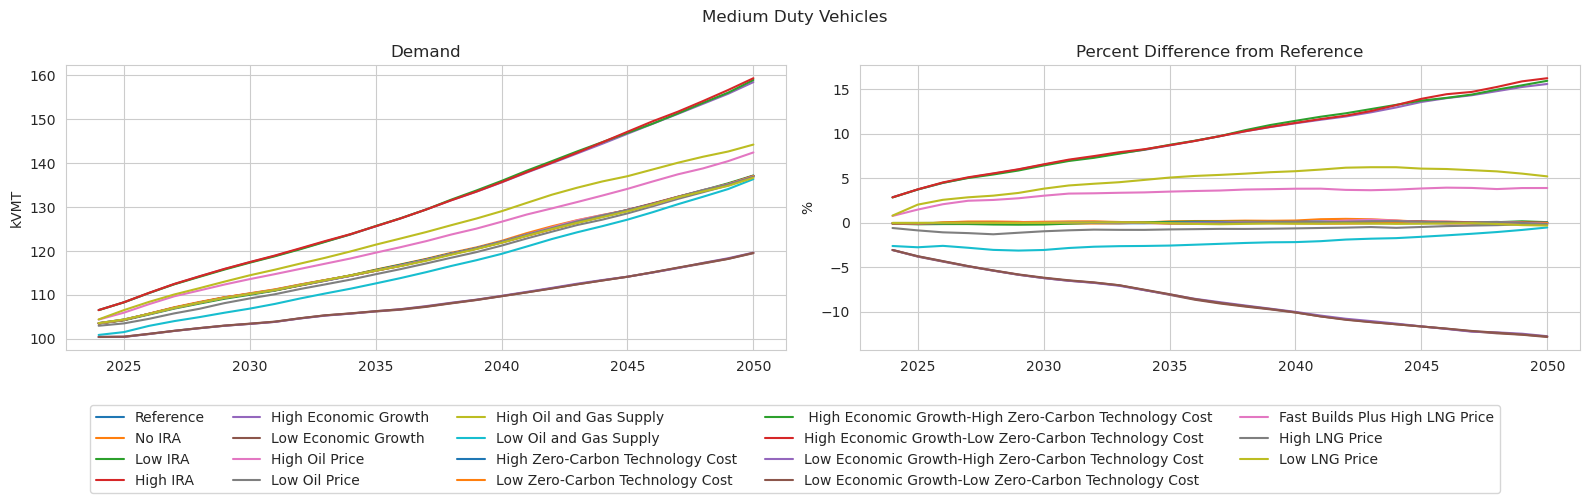

In [13]:
veh = collect_transport_data("med_duty", YEAR, API)
veh_diff = calculate_difference(veh, MIN_MAX_YEAR)
# fig, ax = plot_difference(veh_diff, title="Medium Duty Vehicles")
fig, ax = plot_raw_and_diff(
    veh, 
    veh_diff, 
    title="Medium Duty Vehicles", 
    title_raw="Demand", 
    y_label_raw="kVMT"
)

The minimum differencce before 2035 is: -8.18 %
The maximum differencce before 2035 is: 10.07 %


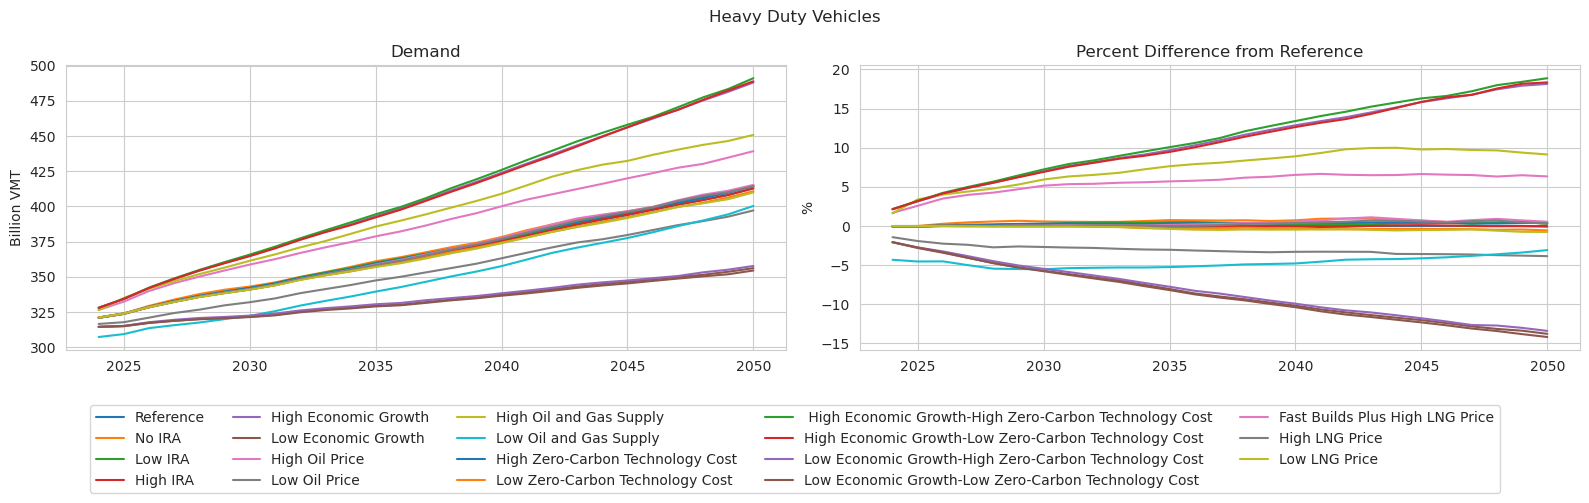

In [14]:
veh = collect_transport_data("heavy_duty", YEAR, API)
veh_diff = calculate_difference(veh, MIN_MAX_YEAR)
# fig, ax = plot_difference(veh_diff, title="Heavy Duty Vehicles")
fig, ax = plot_raw_and_diff(
    veh, 
    veh_diff, 
    title="Heavy Duty Vehicles", 
    title_raw="Demand", 
    y_label_raw="Billion VMT"
)

The minimum differencce before 2035 is: -1.97 %
The maximum differencce before 2035 is: 3.03 %


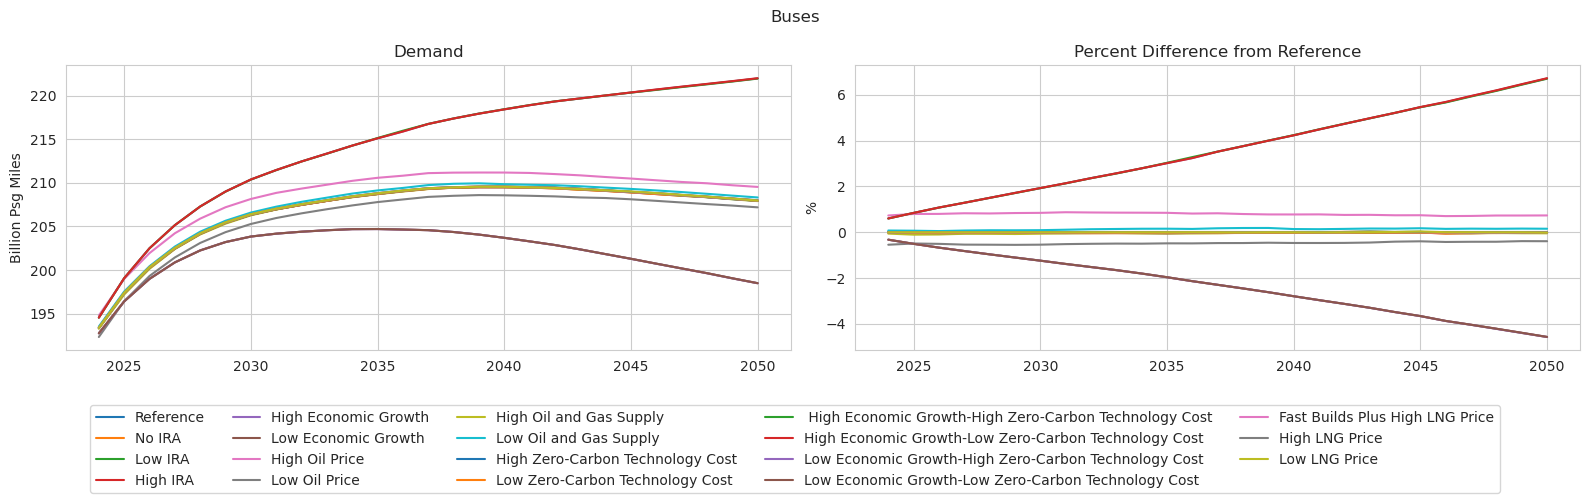

In [15]:
veh = collect_transport_data("bus", YEAR, API)
veh_diff = calculate_difference(veh, MIN_MAX_YEAR)
# fig, ax = plot_difference(veh_diff, title="Buses")
fig, ax = plot_raw_and_diff(
    veh, 
    veh_diff, 
    title="Buses", 
    title_raw="Demand", 
    y_label_raw="Billion Psg Miles"
)

The minimum differencce before 2035 is: -8.29 %
The maximum differencce before 2035 is: 12.94 %


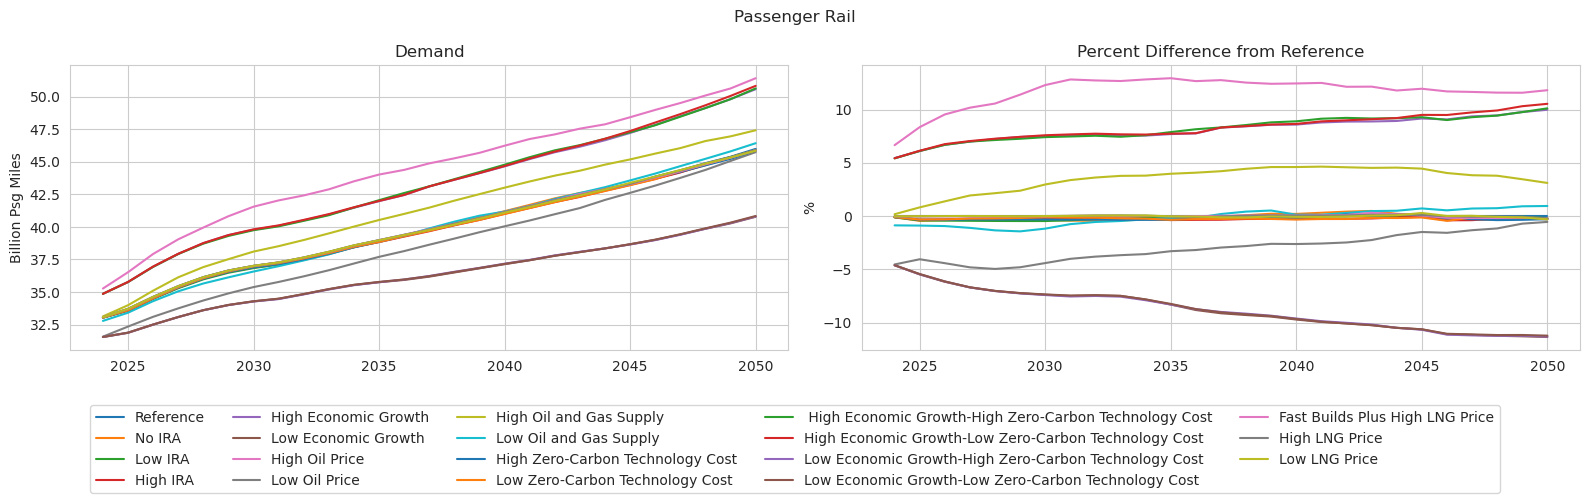

In [16]:
veh = collect_transport_data("rail_passenger", YEAR, API)
veh_diff = calculate_difference(veh, MIN_MAX_YEAR)
# fig, ax = plot_difference(veh_diff, title="Passenger Rail")
fig, ax = plot_raw_and_diff(
    veh, 
    veh_diff, 
    title="Passenger Rail", 
    title_raw="Demand", 
    y_label_raw="Billion Psg Miles"
)

The minimum differencce before 2035 is: -7.32 %
The maximum differencce before 2035 is: 9.02 %


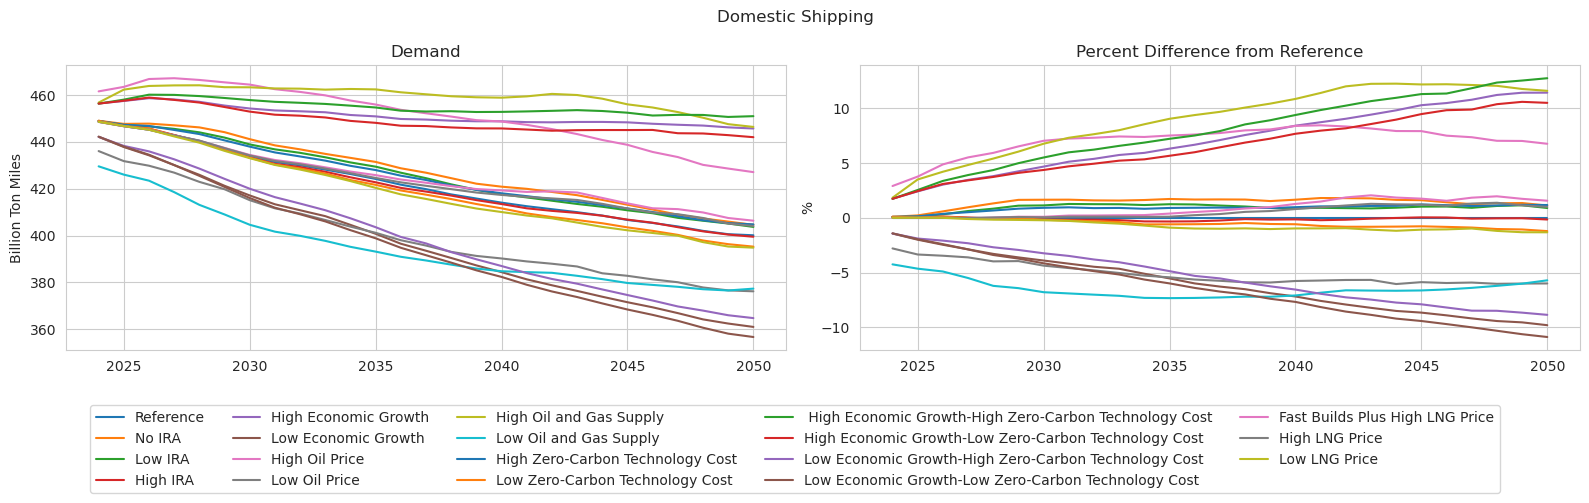

In [17]:
veh = collect_transport_data("boat_shipping", YEAR, API)
veh_diff = calculate_difference(veh, MIN_MAX_YEAR)
# fig, ax = plot_difference(veh_diff, title="Marine Shipping")
fig, ax = plot_raw_and_diff(
    veh, 
    veh_diff, 
    title="Domestic Shipping", 
    title_raw="Demand", 
    y_label_raw="Billion Ton Miles"
)

The minimum differencce before 2035 is: -11.0 %
The maximum differencce before 2035 is: 15.55 %


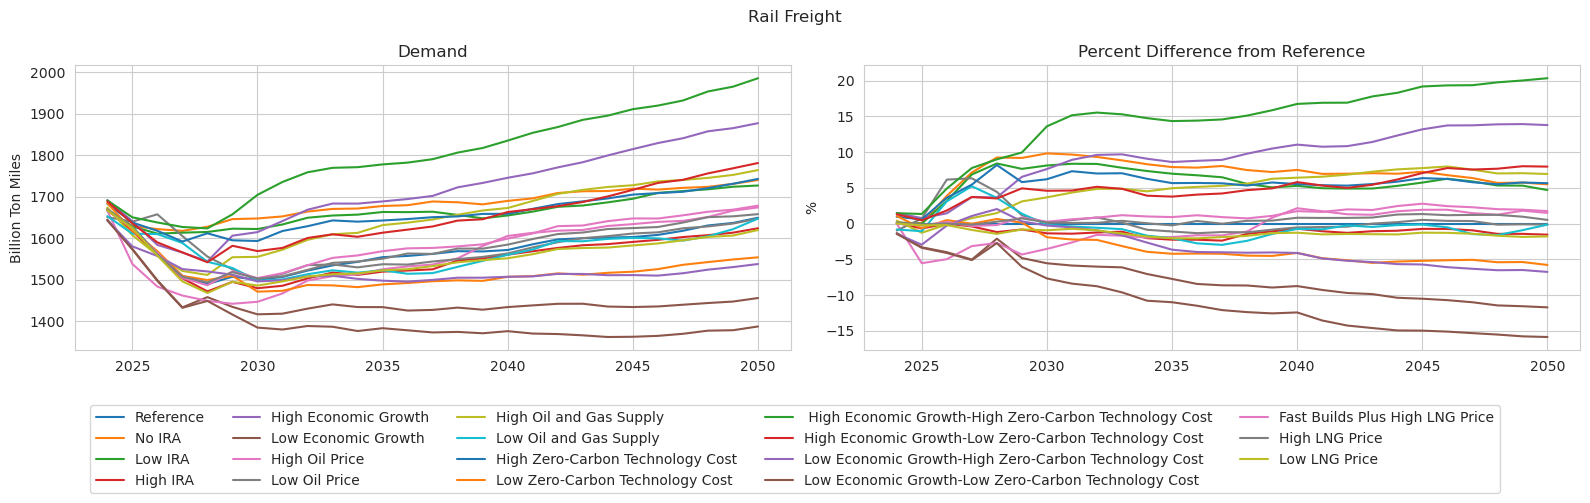

In [18]:
veh = collect_transport_data("rail_shipping", YEAR, API)
veh_diff = calculate_difference(veh, MIN_MAX_YEAR)
# fig, ax = plot_difference(veh_diff, title="Rail Shipping")
fig, ax = plot_raw_and_diff(
    veh, 
    veh_diff, 
    title="Rail Freight", 
    title_raw="Demand", 
    y_label_raw="Billion Ton Miles"
)

The minimum differencce before 2035 is: -7.46 %
The maximum differencce before 2035 is: 8.12 %


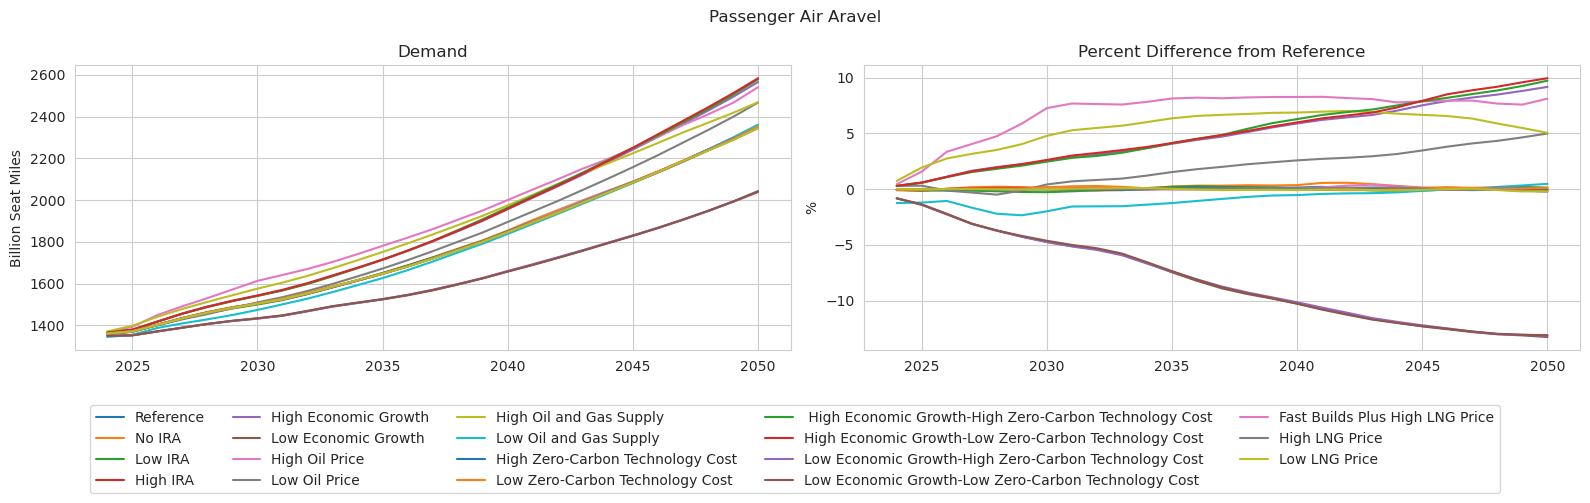

In [19]:
veh = collect_transport_data("air", YEAR, API)
veh_diff = calculate_difference(veh, MIN_MAX_YEAR)
# fig, ax = plot_difference(veh_diff, title="Passenger Air Aravel")
fig, ax = plot_raw_and_diff(
    veh, 
    veh_diff, 
    title="Passenger Air Aravel", 
    title_raw="Demand", 
    y_label_raw="Billion Seat Miles"
)

The minimum differencce before 2035 is: -3.2 %
The maximum differencce before 2035 is: 9.75 %


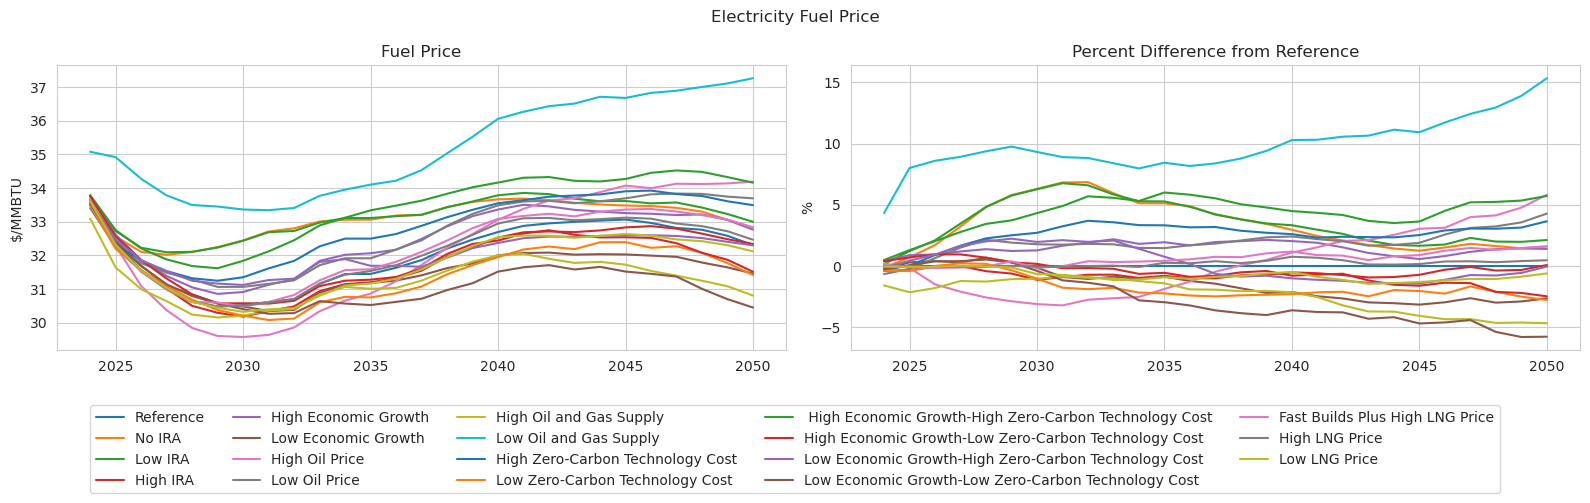

In [20]:
fuel = collect_fuel_data("electricity", YEAR, API)
fuel_diff = calculate_difference(fuel, MIN_MAX_YEAR)
# fig, ax = plot_difference(fuel_diff, title="Electricity Price")
fig, ax = plot_raw_and_diff(
    fuel, 
    fuel_diff, 
    title="Electricity Fuel Price", 
    title_raw="Fuel Price", 
    y_label_raw="$/MMBTU"
)

The minimum differencce before 2035 is: -14.8 %
The maximum differencce before 2035 is: 60.15 %


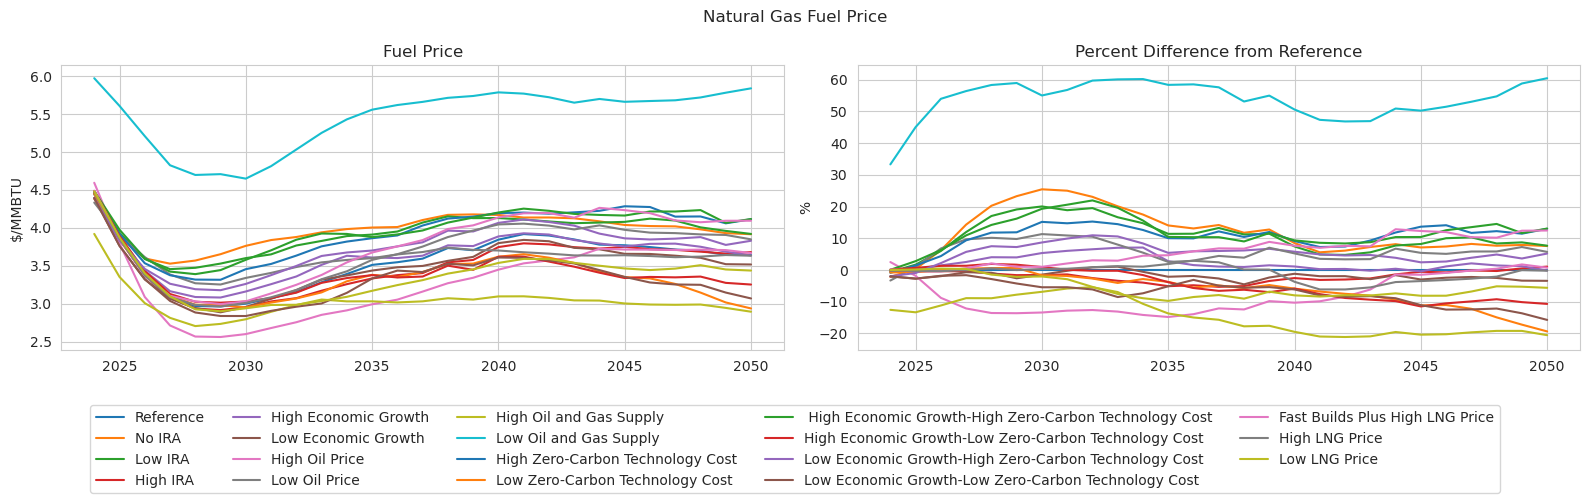

In [21]:
fuel = collect_fuel_data("gas", YEAR, API)
fuel_diff = calculate_difference(fuel, MIN_MAX_YEAR)
# fig, ax = plot_difference(fuel_diff, title="Gas Price")
fig, ax = plot_raw_and_diff(
    fuel, 
    fuel_diff, 
    title="Natural Gas Fuel Price", 
    title_raw="Fuel Price", 
    y_label_raw="$/MMBTU"
)

The minimum differencce before 2035 is: -6.16 %
The maximum differencce before 2035 is: 7.98 %


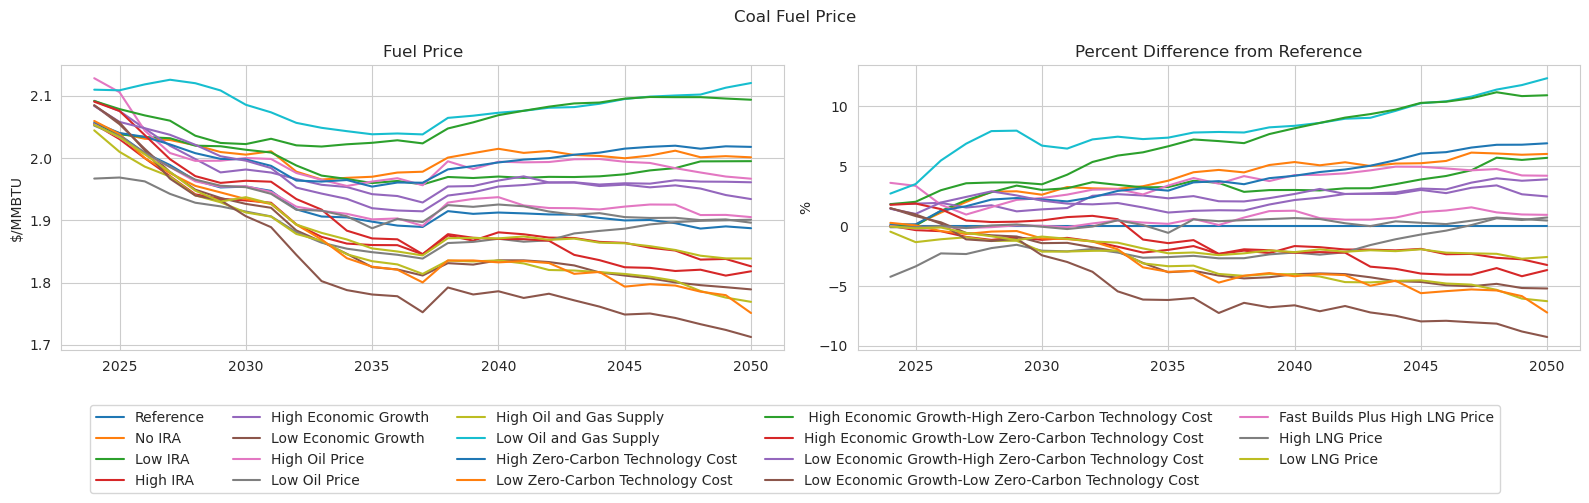

In [22]:
fuel = collect_fuel_data("coal", YEAR, API)
fuel_diff = calculate_difference(fuel, MIN_MAX_YEAR)
# fig, ax = plot_difference(fuel_diff, title="Coal Price")
fig, ax = plot_raw_and_diff(
    fuel, 
    fuel_diff, 
    title="Coal Fuel Price", 
    title_raw="Fuel Price", 
    y_label_raw="$/MMBTU"
)

The minimum differencce before 2035 is: -0.31 %
The maximum differencce before 2035 is: 0.32 %


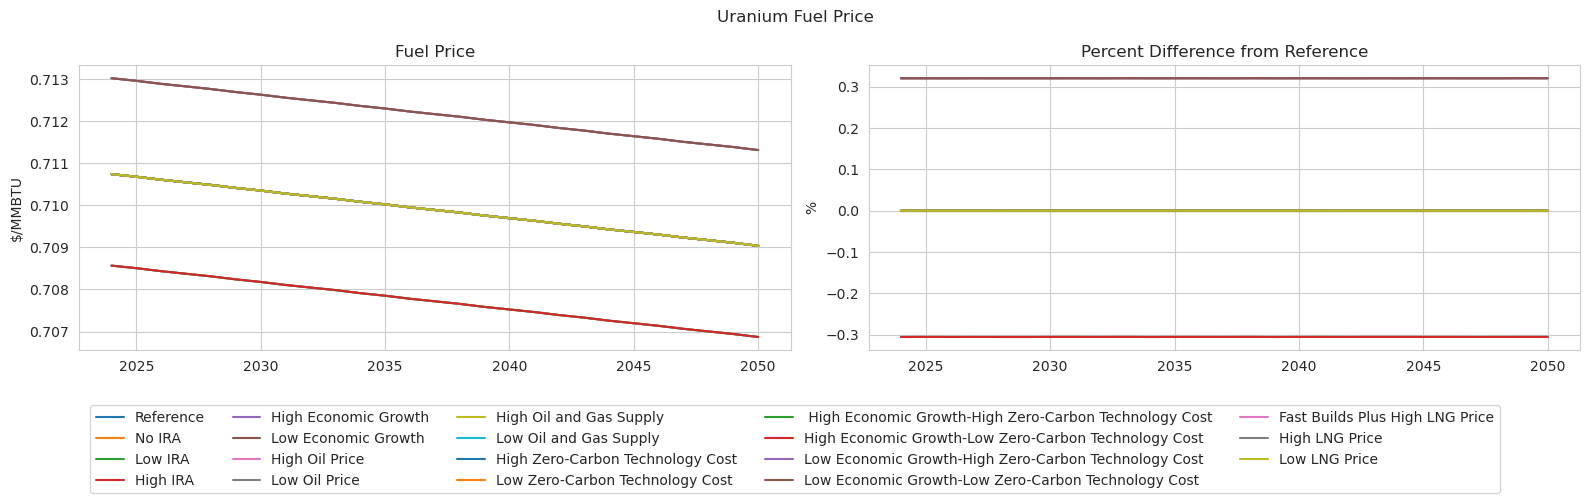

In [23]:
fuel = collect_fuel_data("nuclear", YEAR, API)
fuel_diff = calculate_difference(fuel, MIN_MAX_YEAR)
# fig, ax = plot_difference(fuel_diff, title="Uranium Price")
fig, ax = plot_raw_and_diff(
    fuel, 
    fuel_diff, 
    title="Uranium Fuel Price", 
    title_raw="Fuel Price", 
    y_label_raw="$/MMBTU"
)

The minimum differencce before 2035 is: -28.49 %
The maximum differencce before 2035 is: 59.64 %


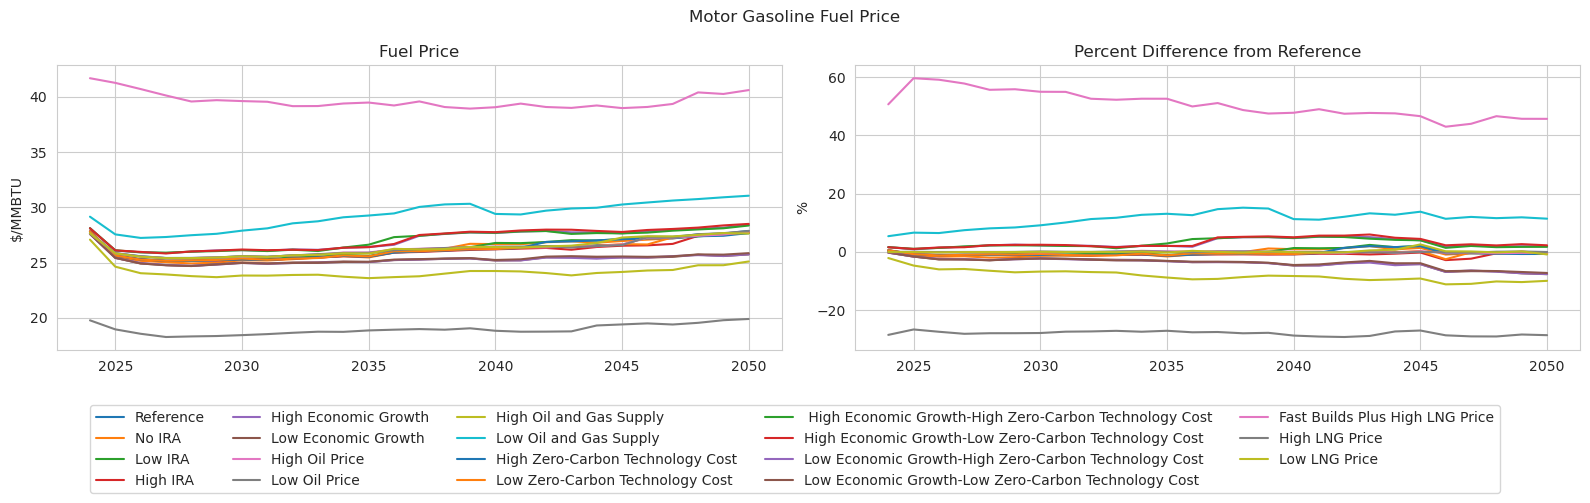

In [24]:
fuel = collect_fuel_data("lpg", YEAR, API)
fuel_diff = calculate_difference(fuel, MIN_MAX_YEAR)
# fig, ax = plot_difference(fuel_diff, title="Motor Gasoline Price")
fig, ax = plot_raw_and_diff(
    fuel, 
    fuel_diff, 
    title="Motor Gasoline Fuel Price", 
    title_raw="Fuel Price", 
    y_label_raw="$/MMBTU"
)

The minimum differencce before 2035 is: -40.06 %
The maximum differencce before 2035 is: 65.97 %


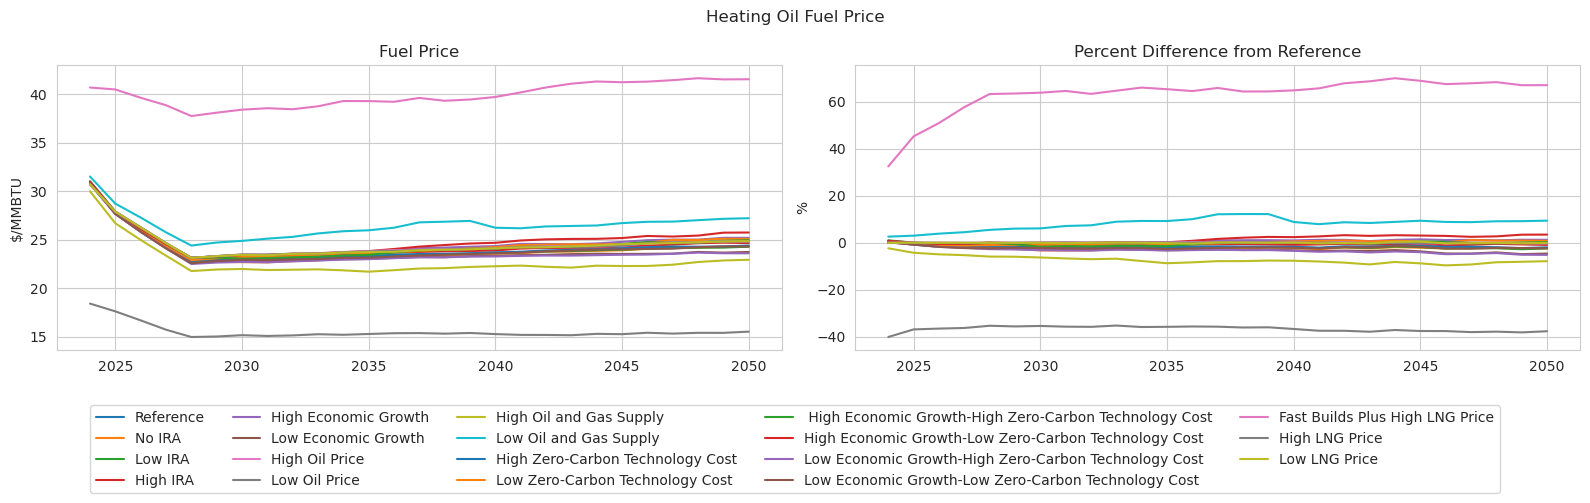

In [25]:
fuel = collect_fuel_data("heating_oil", YEAR, API)
fuel_diff = calculate_difference(fuel, MIN_MAX_YEAR)
# fig, ax = plot_difference(fuel_diff, title="Heating Oil Price")
fig, ax = plot_raw_and_diff(
    fuel, 
    fuel_diff, 
    title="Heating Oil Fuel Price", 
    title_raw="Fuel Price", 
    y_label_raw="$/MMBTU"
)